#### Set up the environment

In [13]:
import numpy as np
import pandas as pd
import os
from glob import glob
import pathlib
import shutil
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import optimizers

In [14]:
np.set_printoptions(suppress=True)

In [15]:
train_dir = pathlib.Path("brain_tumor 2/training")
test_dir = pathlib.Path("brain_tumor 2/validation")
pred_dir = pathlib.Path("brain_tumor 2/test")

batch = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)

Will be using image augmentation as well here

In [16]:
imagegenerator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=30,
                                          width_shift_range=15,
                                          height_shift_range=15,
                                          brightness_range=[0.5, 1.5],
                                          horizontal_flip=True,
                                          vertical_flip=True)
imggen = image.ImageDataGenerator(rescale=1./255)

In [17]:
train_gen = imagegenerator.flow_from_directory(
    train_dir,
    batch_size=batch,
    target_size=img_size,
    seed=2021,
    color_mode='rgb',
    class_mode='binary'
)

test_gen = imggen.flow_from_directory(
    test_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary'
)

pred_gen = imggen.flow_from_directory(
    pred_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 7465 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


#### Transfer learning with MobileNet v2

In [45]:
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [46]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
for layer in base_model.layers:
    layer.trainable = False    

x = base_model.output
x = Flatten()(x) # 
x = Dense(100, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mse'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
result = model.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    validation_steps=10,
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)

Epoch 1/20
234/234 [==============================] - 168s 710ms/step - loss: 0.7927 - accuracy: 0.8538 - mse: 0.1193 - val_loss: 0.3910 - val_accuracy: 0.9156 - val_mse: 0.0700
Epoch 2/20
234/234 [==============================] - 173s 738ms/step - loss: 0.1166 - accuracy: 0.9573 - mse: 0.0314 - val_loss: 0.3579 - val_accuracy: 0.9406 - val_mse: 0.0532
Epoch 3/20
234/234 [==============================] - 171s 731ms/step - loss: 0.1422 - accuracy: 0.9612 - mse: 0.0311 - val_loss: 0.2618 - val_accuracy: 0.9281 - val_mse: 0.0612
Epoch 4/20
234/234 [==============================] - 172s 732ms/step - loss: 0.0772 - accuracy: 0.9729 - mse: 0.0199 - val_loss: 0.1344 - val_accuracy: 0.9375 - val_mse: 0.0418
Epoch 5/20
234/234 [==============================] - 171s 730ms/step - loss: 0.0656 - accuracy: 0.9748 - mse: 0.0184 - val_loss: 0.3848 - val_accuracy: 0.8938 - val_mse: 0.0774
Epoch 6/20
234/234 [==============================] - 145s 620ms/step - loss: 0.0466 - accuracy: 0.9833 - mse:

In [50]:
predictions = model.predict(pred_gen, verbose=1)

48/48 [==============================] - 21s 425ms/step


In [24]:
from sklearn.metrics import accuracy_score, recall_score

In [51]:
print(accuracy_score(pred_gen.classes, predictions.round(0)))
print(recall_score(pred_gen.classes, predictions.round(0)))

0.9821310390469887
0.9940357852882704


Seems that the transfer learned model improved performance ever so slightly versus the custom CNN model with expanded dataset

Evaluating the classification performance below:

Text(93.77777777777786, 0.5, 'actual')

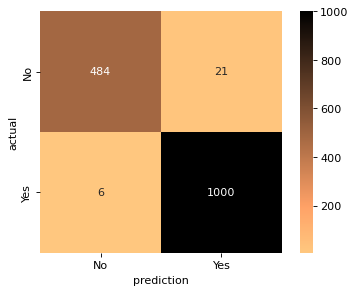

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(pred_gen.classes, predictions.round(0))
plt.figure(dpi=80)
sns.heatmap(conf_mat, cmap=plt.cm.copper_r , annot=True, square=True, fmt='d', 
       xticklabels=['No', 'Yes'],
       yticklabels=['No', 'Yes']);
plt.xlabel('prediction')
plt.ylabel('actual')

Taking a look at the misclassified images

In [53]:
trueclass = pred_gen.classes
predclass = predictions.round(0).reshape(1,-1)

In [54]:
misclassified_list = []

for i in range(0,len(trueclass)):
    if trueclass[i] == predclass[0][i]:
        pass
    else:
        misclassified_list.append(pred_gen.filenames[i])

len(misclassified_list)

27

In [62]:
len(misclassified_list)/len(predclass[0])

0.01786896095301125

In [63]:
misclassified_list

['no/Te-noTr_0004.jpg',
 'no/Te-no_0013.jpg',
 'no/Te-no_0015.jpg',
 'no/Te-no_0023.jpg',
 'no/Te-no_0035.jpg',
 'no/Te-no_0039.jpg',
 'no/Te-no_0045.jpg',
 'no/Te-no_0050.jpg',
 'no/Te-no_0054.jpg',
 'no/Te-no_0081.jpg',
 'no/Te-no_0089.jpg',
 'no/Te-no_0095.jpg',
 'no/Te-no_0098.jpg',
 'no/Te-no_0101.jpg',
 'no/Te-no_0104.jpg',
 'no/Te-no_0105.jpg',
 'no/Te-no_0192.jpg',
 'no/Te-no_0222.jpg',
 'no/no1169.jpg',
 'no/no1189.jpg',
 'no/no1450.jpg',
 'yes/Te-meTr_0002.jpg',
 'yes/Te-me_0112.jpg',
 'yes/Te-me_0140.jpg',
 'yes/y1463.jpg',
 'yes/y1489.jpg',
 'yes/y1491.jpg']

In [56]:
import cv2

In [66]:
y1463 = cv2.imread("brain_tumor 2/test/yes/y1463.jpg")
y1463 = cv2.resize(y1463, (224,224), interpolation=cv2.INTER_AREA)

y1489 = cv2.imread("brain_tumor 2/test/yes/y1489.jpg")
y1489 = cv2.resize(y1489, (224,224), interpolation=cv2.INTER_AREA)

n1169 = cv2.imread("brain_tumor 2/test/no/no1169.jpg")
n1169 = cv2.resize(n1169, (224,224), interpolation=cv2.INTER_AREA)

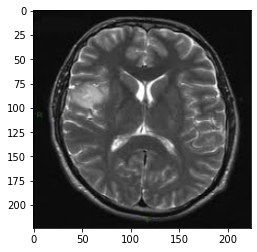

In [37]:
import matplotlib.pyplot as plt
plt.imshow(y1463)

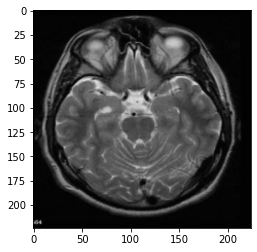

In [68]:
plt.imshow(y1489)

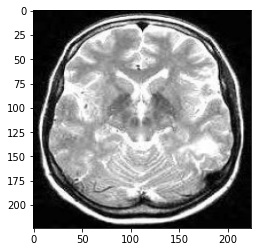

In [67]:
plt.imshow(n1169)

CNN model architecture from codes below can be found in this same folder

In [41]:
import visualkeras

In [42]:
visualkeras.layered_view(model, legend=True, scale_xy=40, background_fill = None).show()

In [43]:
visualkeras.layered_view(model, legend=True).show()

For later use:

In [69]:
model.save("with_mobilenet.h5")

In [21]:
model = tf.keras.models.load_model("with_mobilenet.h5")